In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
train = pd.read_csv("clean_train_reviewsbg.csv")

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [4]:
import gensim

In [5]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=500000)


C:\Users\ngmat\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
def review_to_vector(review):
    ##strip puncation
    review_array = review.split()
    wordvectors = []
    for word in review_array:
        try:
            vector = model.get_vector(word)
            wordvectors.append(vector)
        except KeyError:
            pass
    avg_word_vector = np.mean(np.array(wordvectors), axis=0)
    return avg_word_vector

In [7]:
cleanvector = []
for review in train['cleanReview']:
    cleanvector.append(review_to_vector(review))

In [8]:
X_emreviews = np.array(cleanvector, dtype=np.float)
X_emreviews.shape

(25000, 300)

In [9]:
print(X_emreviews[1])

[ 0.03917618  0.07527008  0.00668135  0.12237892 -0.05514144  0.01250296
  0.04666138 -0.04853227  0.06809974  0.06034899 -0.0264349  -0.13563843
 -0.02281494  0.04036713 -0.0774643   0.1085742   0.03467331  0.12186289
  0.01463499 -0.05926056 -0.03535689  0.07528882  0.02703972  0.00123997
  0.04615135 -0.03957943 -0.09244518  0.0536674   0.00888844 -0.00864553
 -0.06121502 -0.01299958 -0.01968536  0.03419232  0.05326509  0.0030509
  0.03214207  0.04327729  0.05265088  0.09054108  0.11198883 -0.01156807
  0.10114269  0.02941818 -0.02399211 -0.05242996 -0.06253014 -0.00025215
  0.03833618 -0.01486816 -0.01893005  0.03220692 -0.04692974  0.01528053
  0.02531347  0.02246552 -0.04301932 -0.09034767  0.02570829 -0.07500491
  0.01776581  0.09853458 -0.09504414 -0.08185279  0.0098011  -0.03730826
 -0.1026289   0.06098423 -0.02648797  0.07591248  0.0409565  -0.00612602
  0.07162933 -0.02266569 -0.12598877 -0.09535122  0.02087936  0.06742859
  0.06781578  0.10706339 -0.02486682 -0.02205276  0.

In [10]:
train_features, test_features, train_labels, test_labels = train_test_split(X_emreviews, train['sentiment'], test_size = 0.33, random_state = 42)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=9)

In [12]:
model.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [13]:
sen_pred_train = model.predict(train_features)
sen_pred_test = model.predict(test_features)

In [14]:
from sklearn.metrics import accuracy_score
print('accuracy scores training set: ',accuracy_score(train_labels,sen_pred_train))
print('accuracy scores test set: ',accuracy_score(test_labels,sen_pred_test))

accuracy scores training set:  0.8437014925373134
accuracy scores test set:  0.8002424242424242


In [15]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_curve, auc

In [16]:
print(classification_report(test_labels, sen_pred_test)) 

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4105
           1       0.81      0.79      0.80      4145

   micro avg       0.80      0.80      0.80      8250
   macro avg       0.80      0.80      0.80      8250
weighted avg       0.80      0.80      0.80      8250



In [18]:
print(confusion_matrix(test_labels, sen_pred_test)) 

[[3187  918]
 [ 930 3215]]


In [17]:
sen_pred_test_roc = model.predict_proba(test_features)
sen_pred_test_roc_positive = sen_pred_test_roc[:, 1]

In [19]:
from sklearn.metrics import roc_auc_score

In [21]:
auc = roc_auc_score(test_labels, sen_pred_test_roc_positive)
print('AUC: %.2f' % auc)

AUC: 0.87


In [22]:
fpr, tpr, thresholds = roc_curve(test_labels, sen_pred_test_roc_positive)

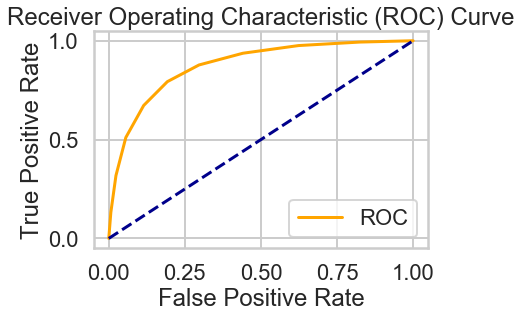

In [23]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV 

In [24]:
param_grid = {'n_neighbors': list(range(1,11))}
  

In [25]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3) 

In [26]:
grid.fit(train_features, train_labels)

C:\Users\ngmat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neighbors=1 ...................................................
[CV] ........... n_neighbors=1, score=0.730121776504298, total= 1.3min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.7239835214042629, total= 1.3min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


[CV] .......... n_neighbors=1, score=0.7239835214042629, total= 1.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.7120343839541547, total= 1.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.7128783807988537, total= 1.4min
[CV] n_neighbors=2 ...................................................
[CV] .......... n_neighbors=2, score=0.7067884649829841, total= 1.5min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.7587750716332379, total= 1.4min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.7605230162994806, total= 1.4min
[CV] n_neighbors=3 ...................................................
[CV] .......... n_neighbors=3, score=0.7565824825362708, total= 1.3min
[CV] n_neighbors=4 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 114.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [27]:
print(grid.best_params_) 

{'n_neighbors': 9}


In [28]:
print(grid.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')


In [30]:
grid_pred_train = grid.predict(train_features)
grid_pred_test = grid.predict(test_features)

In [31]:
print('accuracy scores training set: ',accuracy_score(train_labels,grid_pred_train))
print('accuracy scores test set: ',accuracy_score(test_labels,grid_pred_test))

accuracy scores training set:  0.8437014925373134
accuracy scores test set:  0.8002424242424242


In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
scores = cross_val_score(model, X_emreviews, train['sentiment'], cv=5)

In [34]:
print(scores)

[0.7776 0.7788 0.7712 0.7756 0.768 ]
